## 🧠 Building Expected Passes (xP) for Women’s Football

**Competition Focus:** Elite Women’s International & Club Football  
**Purpose:** Build an Expected Passes (xP) model to quantify pass difficulty and decision-making  
**Methods:** Feature engineering, probabilistic modelling, model evaluation  
**Author:** [Victoria Friss de Kereki](https://www.linkedin.com/in/victoria-friss-de-kereki/)  
**Medium Articles:**  
- [Pass Completion Isn’t Pass Quality — Building Expected Passes (xP) for Women’s Football](https://medium.com/@vickyfrissdekereki/pass-completion-isnt-pass-quality-building-expected-passes-xp-for-women-s-football-84af2e9cd67f)  
- [Building an Expected Passes (xP) Model for Women’s Football in Python](https://medium.com/@vickyfrissdekereki/building-an-expected-passes-xp-model-for-womens-football-in-python-5068a4be6f0d)

---

**Notebook first written:** `04/01/2026`  
**Last updated:** `14/02/2026`  

> This notebook develops an Expected Passes (xP) model tailored to women’s football. The objective is to evaluate passing decisions beyond completion rates by estimating the likelihood of a pass being successfully completed given its context. The approach is modular and can be reused for different datasets, competitions, or extended into possession-value frameworks.
frameworks.


## Packages and configuration

In [1]:
from statsbombpy import sb
import pandas as pd
import numpy as np
from mplsoccer import VerticalPitch,Pitch
from highlight_text import ax_text, fig_text
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import seaborn as sns
import pprint
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

## Load Competiton, Match, and Event Data from statsbombpy

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Call statsbomb API to get all free competitions, then check Women's comps
free_comps = sb.competitions()
women_comps = free_comps[free_comps['competition_gender'] == 'female']
women_comps

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
25,37,90,England,FA Women's Super League,female,False,False,2020/2021,2025-04-23T14:16:46.924831,2021-06-13T16:17:31.694,None,2025-04-23T14:16:46.924831
26,37,42,England,FA Women's Super League,female,False,False,2019/2020,2024-02-12T15:05:34.211400,2021-06-13T16:17:31.694,None,2024-02-12T15:05:34.211400
27,37,4,England,FA Women's Super League,female,False,False,2018/2019,2024-08-07T17:22:40.334287,2021-06-13T16:17:31.694,None,2024-08-07T17:22:40.334287
63,49,3,United States of America,NWSL,female,False,False,2018,2024-12-15T12:31:48.035735,2021-06-13T16:17:31.694,None,2024-12-15T12:31:48.035735
71,53,315,Europe,UEFA Women's Euro,female,False,True,2025,2025-07-28T14:19:20.467348,2025-07-29T16:03:07.355174,2025-07-29T16:03:07.355174,2025-07-28T14:19:20.467348
72,53,106,Europe,UEFA Women's Euro,female,False,True,2022,2024-02-13T13:27:17.178263,2024-02-13T13:30:52.820588,2024-02-13T13:30:52.820588,2024-02-13T13:27:17.178263
73,72,107,International,Women's World Cup,female,False,True,2023,2025-07-14T10:07:06.620906,2025-07-14T10:10:27.224586,2025-07-14T10:10:27.224586,2025-07-14T10:07:06.620906
74,72,30,International,Women's World Cup,female,False,True,2019,2024-08-08T15:57:56.748740,2021-06-13T16:17:31.694,None,2024-08-08T15:57:56.748740


## All women's matches

In [3]:
all_matches = []

for _, row in women_comps.iterrows():
    matches = sb.matches(
        competition_id=row["competition_id"],
        season_id=row["season_id"]
    )
    all_matches.append(matches)

matches_df = pd.concat(all_matches, ignore_index=True)

In [4]:
len(matches_df)

540

## All events, then keep passes only

In [5]:
CACHE_DIR = Path("statsbomb_cache/events")
CACHE_DIR.mkdir(parents=True, exist_ok=True)


def load_events(match_id):
    cache_file = CACHE_DIR / f"{match_id}.parquet"

    if cache_file.exists():
        return pd.read_parquet(cache_file)

    events = sb.events(match_id=match_id)
    events.to_parquet(cache_file)
    return events

In [6]:
all_passes = []

for match_id in matches_df["match_id"]:
    events = load_events(match_id)
    passes = events[events["type"] == "Pass"]
    all_passes.append(passes)

passes_df = pd.concat(all_passes, ignore_index=True)

In [7]:
len(passes_df)

496100

In [8]:
passes_df.head(2)

,50_50,ball_receipt_outcome,ball_recovery_recovery_failure,block_deflection,block_offensive,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,clearance_right_foot,counterpress,dribble_nutmeg,dribble_outcome,duel_outcome,duel_type,duration,foul_committed_advantage,foul_committed_card,foul_committed_type,foul_won_advantage,foul_won_defensive,goalkeeper_body_part,goalkeeper_end_location,goalkeeper_outcome,goalkeeper_position,goalkeeper_punched_out,goalkeeper_technique,goalkeeper_type,id,index,interception_outcome,location,match_id,minute,off_camera,out,pass_aerial_won,pass_angle,pass_assisted_shot_id,pass_body_part,pass_cross,pass_cut_back,pass_deflected,pass_end_location,pass_goal_assist,pass_height,pass_inswinging,pass_length,pass_miscommunication,pass_no_touch,pass_outcome,pass_outswinging,pass_recipient,pass_recipient_id,pass_shot_assist,pass_straight,pass_switch,pass_technique,pass_through_ball,pass_type,period,play_pattern,player,player_id,position,possession,possession_team,possession_team_id,related_events,second,shot_aerial_won,shot_body_part,shot_end_location,shot_first_time,shot_freeze_frame,shot_key_pass_id,shot_one_on_one,shot_open_goal,shot_outcome,shot_statsbomb_xg,shot_technique,shot_type,substitution_outcome,substitution_outcome_id,substitution_replacement,substitution_replacement_id,tactics,team,team_id,timestamp,type,under_pressure,dribble_overrun,injury_stoppage_in_chain,clearance_other,goalkeeper_shot_saved_off_target,shot_deflected,shot_saved_off_target,foul_committed_offensive,foul_committed_penalty,foul_won_penalty,miscontrol_aerial_won,shot_redirect,ball_recovery_offensive,block_save_block,goalkeeper_success_in_play,bad_behaviour_card,dribble_no_touch,shot_follows_dribble,goalkeeper_saved_to_post,half_start_late_video_start,goalkeeper_shot_saved_to_post,shot_saved_to_post,goalkeeper_lost_out,goalkeeper_lost_in_play,half_end_early_video_end,pass_backheel,player_off_permanent,goalkeeper_success_out,goalkeeper_penalty_saved_to_post,shot_kick_off
0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0.311672,None,None,None,None,None,None,None,None,None,None,None,None,4c33f2eb-7392-419d-b6ac-bedaa573ddc6,5,None,"[61.0, 40.1]",3775648,0,None,None,None,1.144169,None,Right Foot,None,None,None,"[62.0, 42.3]",None,Ground Pass,None,2.416609,None,None,None,None,Bethany Mead,15619.0,None,None,None,None,None,Kick Off,1,From Kick Off,Vivianne Miedema,15623.0,Left Wing,2,Arsenal WFC,968,[a2016066-fbb9-4d5a-8f6b-2f9d7411a4dd],0,None,None,None,None,None,None,None,None,None,NaN,None,None,None,NaN,None,NaN,None,Arsenal WFC,968,00:00:00.340,Pass,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1.125058,None,None,None,None,None,None,None,None,None,None,None,None,4467e274-205f-41be-ab7e-62ece2697dbc,8,None,"[59.3, 40.8]",3775648,0,None,None,None,-3.089616,None,Right Foot,None,None,None,"[42.0, 39.9]",None,Ground Pass,None,17.323395,None,None,None,None,Lia Wälti,10405.0,None,None,None,None,None,None,1,From Kick Off,Bethany Mead,15619.0,Center Forward,2,Arsenal WFC,968,[0e9e4a0c-46ea-4aea-9c62-b4883bf1d993],0,None,None,None,None,None,None,None,None,None,NaN,None,None,None,NaN,None,NaN,None,Arsenal WFC,968,00:00:00.692,Pass,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
passes_df["play_pattern"].unique()

array(['From Kick Off', 'Regular Play', 'From Keeper', 'From Free Kick',
       'From Throw In', 'From Corner', 'From Counter', 'From Goal Kick',
       'Other'], dtype=object)

## Check pass start and end locations

In [10]:
df = passes_df.copy()

PITCH_LENGTH = 120
PITCH_WIDTH = 80

# Extract coordinates
df["start_x"] = df["location"].str[0]
df["start_y"] = df["location"].str[1]
df["end_x"] = df["pass_end_location"].str[0]
df["end_y"] = df["pass_end_location"].str[1]

# Start location checks
start_outside = df[
    (df["start_x"] < 0) | (df["start_x"] > PITCH_LENGTH) |
    (df["start_y"] < 0) | (df["start_y"] > PITCH_WIDTH)
]

# End (reception) location checks
end_outside = df[
    (df["end_x"] < 0) | (df["end_x"] > PITCH_LENGTH) |
    (df["end_y"] < 0) | (df["end_y"] > PITCH_WIDTH)
]

print(f"Start locations outside pitch: {len(start_outside)}")
print(f"End locations outside pitch: {len(end_outside)}")

Start locations outside pitch: 10
End locations outside pitch: 41


In [11]:
start_outside[[
    "start_x",
    "start_y",
    "team",
    "player",
    "play_pattern",
    "pass_type",
    "pass_outcome"
]].sort_values(["start_x", "start_y"])

,start_x,start_y,team,player,play_pattern,pass_type,pass_outcome
153125,21.8,80.2,Brighton & Hove Albion WFC,Matilde Lundorf Skovsen,From Throw In,None,None
177719,30.4,80.2,Bristol City WFC,Loren Dykes,From Throw In,None,None
175716,44.6,80.1,Liverpool WFC,Melissa Lawley,From Throw In,None,Incomplete
171959,50.4,80.2,West Ham United LFC,Kate Longhurst,Regular Play,None,None
175906,54.9,80.1,Liverpool WFC,Rebecca Jane,From Goal Kick,None,Incomplete
175754,58.6,80.2,Liverpool WFC,Rebecca Jane,From Throw In,None,None
175905,60.0,80.1,Liverpool WFC,Jessica Anne Clarke,From Goal Kick,None,None
175931,71.7,80.2,Liverpool WFC,Rebecca Jane,From Throw In,None,None
175686,74.5,80.2,Liverpool WFC,Rebecca Jane,From Throw In,None,None
171517,120.4,27.5,West Ham United LFC,Kate Longhurst,From Throw In,None,Out


In [12]:
end_outside[[
    "end_x",
    "end_y",
    "team",
    "player",
    "play_pattern",
    "pass_type",
    "pass_outcome"
]].sort_values(["end_x", "end_y"]).head()

,end_x,end_y,team,player,play_pattern,pass_type,pass_outcome
171483,10.1,80.9,West Ham United LFC,Laura Vetterlein,From Throw In,None,Out
172280,11.8,80.9,Arsenal WFC,Leah Williamson,From Free Kick,None,Out
177871,47.0,80.9,Bristol City WFC,Yana Daniëls,Regular Play,None,Out
171958,50.4,80.2,West Ham United LFC,Gilly Louise Scarlett Flaherty,Regular Play,None,None
175871,50.4,80.9,Liverpool WFC,Leigh-Anne Robe,From Free Kick,None,Out


In [13]:
# End (reception) location checks
throwins = df[
    (df["play_pattern"] == "From Throw In") | (df["start_x"] > PITCH_LENGTH) |
    (df["play_pattern"] == "From Throw In") | (df["end_y"] > PITCH_WIDTH)
]

throwins[[
    "start_x",
    "start_y",
    "team",
    "player",
    "play_pattern",
    "pass_type",
    "pass_outcome"
]].sort_values(["start_x", "start_y"])

,start_x,start_y,team,player,play_pattern,pass_type,pass_outcome
9818,0.7,67.1,Birmingham City WFC,Sarah Emma Mayling,From Throw In,None,Out
66262,0.8,45.2,Bristol City WFC,Sophie Baggaley,From Throw In,None,None
25315,0.8,80.0,Arsenal WFC,Lisa Evans,From Throw In,Throw-in,Incomplete
435396,0.9,0.1,Canada Women's,Allysha Lyn Chapman,From Throw In,Throw-in,None
493446,0.9,5.1,Netherlands Women's,Merel van Dongen,From Throw In,None,Out
...,...,...,...,...,...,...,...
124584,120.0,67.2,Everton LFC,Chloe Kelly,From Throw In,None,Incomplete
331894,120.0,73.1,Spain Women's,Aitana Bonmati Conca,From Throw In,None,None
290874,120.0,74.0,Arsenal WFC,Lisa Evans,From Throw In,None,Incomplete
305710,120.0,77.0,NJ/NY Gotham FC,Madison Tiernan,From Throw In,None,Incomplete


### Pass start position

In [14]:
df["completed"] = df["pass_outcome"].isna().astype(int)

In [15]:
# Filter out passes that are Injury Clearance first
df = df[df["pass_outcome"].ne("Injury Clearance")]

# Define pitch bins (10x10 squares grid)
x_bins = np.linspace(0, 120, 13)
y_bins = np.linspace(0, 80, 9)

df["x_zone"] = pd.cut(df["start_x"], bins=x_bins, labels=False)
df["y_zone"] = pd.cut(df["start_y"], bins=y_bins, labels=False)

In [16]:
zone_stats = (
    df
    .groupby(["x_zone", "y_zone"])
    .agg(
        passes=("completed", "count"),
        completion_rate=("completed", "mean")
    )
    .reset_index()
)

In [17]:
# If not too many passes in a zone, ignore zone.
zone_stats = zone_stats[zone_stats["passes"] >= 20]

In [18]:
completion_grid = zone_stats.pivot(
    index="y_zone",
    columns="x_zone",
    values="completion_rate"
)

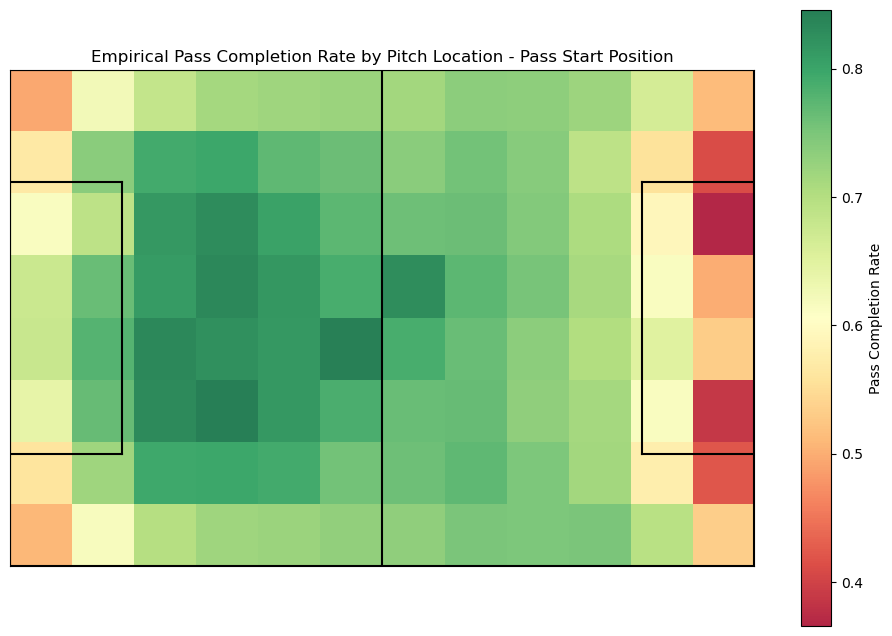

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))

# Pitch outline. StatsBomb’s default pitch dimensions are 120x80
ax.plot([0, 120, 120, 0, 0], [0, 0, 80, 80, 0], color="black")
ax.plot([60, 60], [0, 80], color="black")

# Penalty areas
ax.plot([102, 120], [18, 18], color="black")
ax.plot([102, 102], [18, 62], color="black")
ax.plot([102, 120], [62, 62], color="black")

ax.plot([0, 18], [18, 18], color="black")
ax.plot([18, 18], [18, 62], color="black")
ax.plot([0, 18], [62, 62], color="black")

# Heatmap of completion rate
im = ax.imshow(
    completion_grid.values,
    extent=[0, 120, 0, 80],
    origin="lower",
    cmap="RdYlGn", #RedYellowGreen
    alpha=0.85
)

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Pass Completion Rate")

# Formatting
ax.set_title("Empirical Pass Completion Rate by Pitch Location - Pass Start Position")
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect("equal")

plt.savefig("heatmap_start.png", dpi=300, bbox_inches="tight")

plt.show()

### Pass end position

In [20]:
# Filter out passes that are Injury Clearance first
df = df[df["pass_outcome"].ne("Injury Clearance")]

# Define pitch bins (10-yard grid)
x_bins = np.linspace(0, 120, 13)
y_bins = np.linspace(0, 80, 9)

df["x_zone"] = pd.cut(df["end_x"], bins=x_bins, labels=False)
df["y_zone"] = pd.cut(df["end_y"], bins=y_bins, labels=False)

In [21]:
zone_stats = (
    df
    .groupby(["x_zone", "y_zone"])
    .agg(
        passes=("completed", "count"),
        completion_rate=("completed", "mean")
    )
    .reset_index()
)

In [22]:
zone_stats = zone_stats[zone_stats["passes"] >= 20]

In [23]:
completion_grid = zone_stats.pivot(
    index="y_zone",
    columns="x_zone",
    values="completion_rate"
)

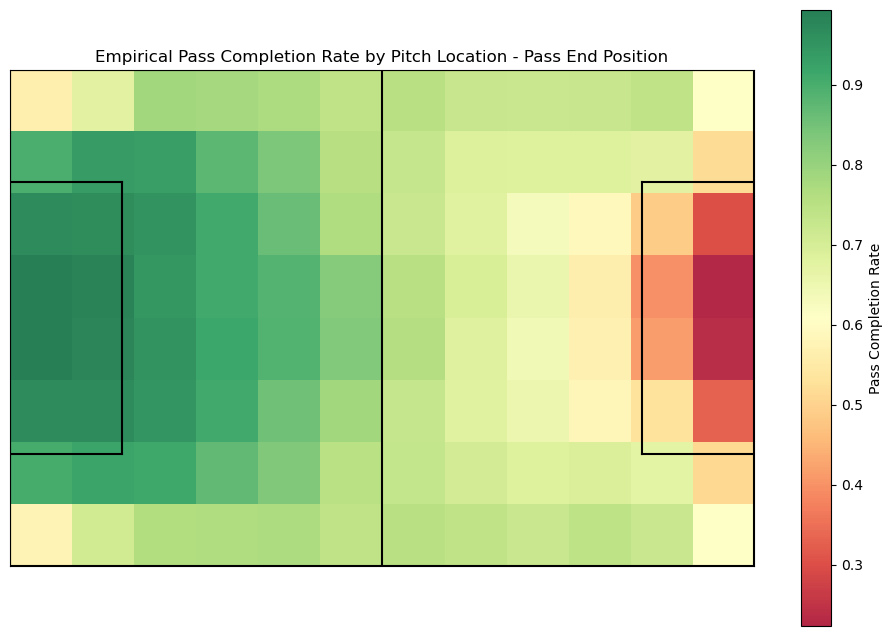

In [24]:
fig, ax = plt.subplots(figsize=(12, 8))

# Pitch outline
ax.plot([0, 120, 120, 0, 0], [0, 0, 80, 80, 0], color="black")
ax.plot([60, 60], [0, 80], color="black")

# Penalty areas
ax.plot([102, 120], [18, 18], color="black")
ax.plot([102, 102], [18, 62], color="black")
ax.plot([102, 120], [62, 62], color="black")

ax.plot([0, 18], [18, 18], color="black")
ax.plot([18, 18], [18, 62], color="black")
ax.plot([0, 18], [62, 62], color="black")

# Heatmap of completion rate
im = ax.imshow(
    completion_grid.values,
    extent=[0, 120, 0, 80],
    origin="lower",
    cmap="RdYlGn",
    alpha=0.85
)

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Pass Completion Rate")

# Formatting
ax.set_title("Empirical Pass Completion Rate by Pitch Location - Pass End Position")
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect("equal")

plt.savefig("heatmap_end.png", dpi=300, bbox_inches="tight")

plt.show()

## Feature engineering

In [25]:
def prepare_pass_features(df_passes):
    df = df_passes.copy()

    META_COLS = ["match_id", "team", "player"]

    PITCH_LENGTH = 120
    PITCH_WIDTH = 80
    GOAL_X = PITCH_LENGTH
    GOAL_Y = PITCH_WIDTH / 2

    # Start / end locations
    df["start_x"] = df["location"].str[0].clip(0, PITCH_LENGTH)
    df["start_y"] = df["location"].str[1].clip(0, PITCH_WIDTH)
    df["end_x"] = df["pass_end_location"].str[0].clip(0, PITCH_LENGTH)
    df["end_y"] = df["pass_end_location"].str[1].clip(0, PITCH_WIDTH)

    df = df[df["pass_outcome"].ne("Injury Clearance")].copy()

    # Spatial bins (10-yard grid)
    x_bins = np.linspace(0, PITCH_LENGTH, 13)
    y_bins = np.linspace(0, PITCH_WIDTH, 9)

    df["start_x_zone"] = pd.cut(df["start_x"], bins=x_bins, labels=False, include_lowest=True)
    df["start_y_zone"] = pd.cut(df["start_y"], bins=y_bins, labels=False, include_lowest=True)
    df["end_x_zone"] = pd.cut(df["end_x"], bins=x_bins, labels=False, include_lowest=True)
    df["end_y_zone"] = pd.cut(df["end_y"], bins=y_bins, labels=False, include_lowest=True)

    df = df.dropna(
        subset=["start_x_zone", "start_y_zone", "end_x_zone", "end_y_zone"]
    ).copy()

    df["start_x_zone"] = df["start_x_zone"].clip(0, 11).astype("int8")
    df["start_y_zone"] = df["start_y_zone"].clip(0, 7).astype("int8")
    df["end_x_zone"] = df["end_x_zone"].clip(0, 11).astype("int8")
    df["end_y_zone"] = df["end_y_zone"].clip(0, 7).astype("int8")

    # Start square encoding
    df["start_square"] = (
        df["start_x_zone"].astype(str) + "_" +
        df["start_y_zone"].astype(str)
    )

    # End square encoding
    df["end_square"] = (
        df["end_x_zone"].astype(str) + "_" +
        df["end_y_zone"].astype(str)
    )

    all_squares = [f"{i}_{j}" for i in range(12) for j in range(8)]

    start_square_dummies = (
        pd.get_dummies(df["start_square"], prefix="sq_start")
        .reindex(columns=[f"sq_start_{s}" for s in all_squares], fill_value=0)
    )

    end_square_dummies = (
        pd.get_dummies(df["end_square"], prefix="sq_end")
        .reindex(columns=[f"sq_end_{s}" for s in all_squares], fill_value=0)
    )

    df = pd.concat([df, start_square_dummies, end_square_dummies], axis=1)

    # Distances and progression
    df["pass_distance"] = np.hypot(
        df["end_x"] - df["start_x"],
        df["end_y"] - df["start_y"]
    )

    df["start_dist_goal"] = np.hypot(
        GOAL_X - df["start_x"],
        GOAL_Y - df["start_y"]
    )

    df["end_dist_goal"] = np.hypot(
        GOAL_X - df["end_x"],
        GOAL_Y - df["end_y"]
    )

    df["progression"] = df["start_dist_goal"] - df["end_dist_goal"]
    df["progressive"] = (df["progression"] > 10).astype("int8")

    df["progressive_opp_half"] = (
        df["progressive"] * (df["start_x_zone"] >= 6)
    ).astype("int8")

    df["central_progressive"] = (
        df["progressive"] * df["start_y_zone"].between(3, 5)
    ).astype("int8")

    # Pass context flags
    df["under_pressure"] = df["under_pressure"].eq(True).astype("int8")
    df["cross"] = df["pass_cross"].eq(True).astype("int8")
    df["through_ball"] = df["pass_through_ball"].eq(True).astype("int8")
    df["switch"] = df["pass_switch"].eq(True).astype("int8")

    df["cross_under_pressure"] = (
        df["cross"] * df["under_pressure"]
    ).astype("int8")

    df["long_pass"] = (df["pass_distance"] > 25).astype("int8")
    df["very_long_pass"] = (df["pass_distance"] > 40).astype("int8")

    df["long_under_pressure"] = (
        df["long_pass"] * df["under_pressure"]
    ).astype("int8")

    df["high_pass"] = (
        df["pass_height"] == "High Pass"
    ).astype("int8")

    # Play pattern encoding
    play_pattern_dummies = pd.get_dummies(
        df["play_pattern"], prefix="pp", drop_first=True
    )
    df = pd.concat([df, play_pattern_dummies], axis=1)

    df["completed"] = df["pass_outcome"].isna().astype("int8")

    FEATURES = [
        "pass_distance",
        "progression",
        "start_dist_goal",
        "under_pressure",
        "high_pass",
        "through_ball",
        "cross",
        "switch",
        "long_under_pressure",
        "very_long_pass",
        "progressive_opp_half",
        "cross_under_pressure",
        "central_progressive",
    ]

    FEATURES += list(play_pattern_dummies.columns)
    FEATURES += list(start_square_dummies.columns)
    FEATURES += list(end_square_dummies.columns)

    X = df[FEATURES]
    y = df["completed"]

    META_COLS = [c for c in META_COLS if c in df.columns]
    meta = df[META_COLS].copy()

    return df, X, y, FEATURES, meta


In [26]:
df, X, y, FEATURES, meta = prepare_pass_features(passes_df)

In [27]:
meta.columns

Index(['match_id', 'team', 'player'], dtype='object')

## Train global xP model

In [28]:
# Fit expected pass completion (xP) model

# Simple logistic regression is enough here.
# The goal is interpretability, not squeezing every last % of performance.
model = LogisticRegression(max_iter=1000)

model.fit(X, y)

# Check coefficients to see if they make football sense
coef_table = pd.DataFrame({
    "feature": FEATURES,
    "coef": model.coef_[0]
}).sort_values("coef")

coef_table

,feature,coef
124,sq_end_0_7,-2.499176
117,sq_end_0_0,-2.363904
132,sq_end_1_7,-1.447047
210,sq_end_11_5,-1.249231
212,sq_end_11_7,-1.194873
...,...,...
108,sq_start_10_7,0.927036
101,sq_start_10_0,0.962855
121,sq_end_0_4,0.975368
120,sq_end_0_3,1.172262


In [29]:
# --------------------------------------------------
# Generate expected completion probability (xP)
# --------------------------------------------------

df["xP"] = model.predict_proba(X)[:, 1]

# Basic discrimination check
auc = roc_auc_score(y, df["xP"])
print(f"AUC: {auc:.3f}")


AUC: 0.845


## Apply the xP model to Euros and Worlds final matches

In [30]:
matches_euros = sb.matches(competition_id=53, season_id=315) 
matches_worlds = sb.matches(competition_id=72, season_id=107)

In [31]:
final_euros = matches_euros[matches_euros['competition_stage'] == 'Final'].iloc[0] 
final_euros_id = final_euros['match_id']
events_final_euros = sb.events(match_id=final_euros_id)

In [32]:
final_world = matches_worlds[matches_worlds['competition_stage'] == 'Final'].iloc[0] 
final_world_id = final_world['match_id']
events_final_world = sb.events(match_id=final_world_id)

In [33]:
# Filter only passes

passes_final_euros = events_final_euros[events_final_euros['type'] == 'Pass'].copy()
passes_final_euros = passes_final_euros[passes_final_euros['pass_outcome'].ne("Injury Clearance")]

passes_final_world = events_final_world[events_final_world['type'] == 'Pass'].copy()
passes_final_world = passes_final_world[passes_final_world['pass_outcome'].ne("Injury Clearance")]

In [34]:
# Feature engineering for Euros final
df_euros_feat, X_euros, y_euros, FEATURES_euros, meta_euros = prepare_pass_features(passes_final_euros)

# Feature engineering for Worlds final
df_world_feat, X_world, y_world, FEATURES_world, meta_world = prepare_pass_features(passes_final_world)

In [35]:
meta_euros.columns

Index(['match_id', 'team', 'player'], dtype='object')

In [36]:
def aggregate_xP(df_feat, X, meta, model):
    df = df_feat.copy()
    X_use = X.copy()

    # Align features with model
    model_features = model.feature_names_in_
    for col in model_features:
        if col not in X_use.columns:
            X_use[col] = 0
    X_use = X_use[model_features]

    # Predict xP per pass
    df["xP"] = model.predict_proba(X_use)[:, 1]

    # Attach metadata without duplicating columns
    meta_use = meta.loc[:, ~meta.columns.isin(df.columns)]
    df = pd.concat(
        [df.reset_index(drop=True), meta_use.reset_index(drop=True)],
        axis=1
    )

    # Team-level aggregation
    team_stats = (
        df.groupby("team")
        .agg(
            total_passes=("completed", "count"),
            completed_passes=("completed", "sum"),
            total_xP=("xP", "sum"),
        )
        .reset_index()
    )
    team_stats["completion_rate_basic"] = team_stats["completed_passes"] / team_stats["total_passes"]
    team_stats["diff"] = team_stats["completed_passes"] - team_stats["total_xP"]
    team_stats["diff%"] = (team_stats["completed_passes"] - team_stats["total_xP"])/team_stats["total_passes"]

    # Player-level aggregation (keep country)
    player_stats = (
        df.groupby(["player", "team"])
        .agg(
            total_passes=("completed", "count"),
            completed_passes=("completed", "sum"),
            total_xP=("xP", "sum"),
        )
        .reset_index()
    )
    player_stats["completion_rate_basic"] = player_stats["completed_passes"] / player_stats["total_passes"]
    player_stats["diff"] = player_stats["completed_passes"] - player_stats["total_xP"]
    player_stats["diff%"] = (player_stats["completed_passes"] - player_stats["total_xP"])/player_stats["total_passes"]

    return {
        "team": team_stats,
        "player": player_stats
    }

In [37]:
euros_results = aggregate_xP(df_euros_feat, X_euros, meta_euros, model)
world_results = aggregate_xP(df_world_feat, X_world, meta_world, model)

team_euros = euros_results["team"]
player_euros = euros_results["player"]

team_world = world_results["team"]
player_world = world_results["player"]

In [38]:
team_euros

,team,total_passes,completed_passes,total_xP,completion_rate_basic,diff,diff%
0,England Women's,473,341,339.867335,0.720930,1.132665,0.002395
1,Spain Women's,832,699,647.834113,0.840144,51.165887,0.061497


In [39]:
player_euros

,player,team,total_passes,completed_passes,total_xP,completion_rate_basic,diff,diff%
0,Aitana Bonmati Conca,Spain Women's,86,73,68.078933,0.848837,4.921067,0.057222
1,Alessia Russo,England Women's,8,4,6.217734,0.500000,-2.217734,-0.277217
2,Alex Greenwood,England Women's,51,42,39.216904,0.823529,2.783096,0.054571
3,Alexia Putellas Segura,Spain Women's,49,39,36.620791,0.795918,2.379209,0.048555
4,Athenea del Castillo Belvide,Spain Women's,29,19,19.161704,0.655172,-0.161704,-0.005576
5,Bethany Mead,England Women's,5,5,4.298112,1.000000,0.701888,0.140378
6,Catalina Thomas Coll Lluch,Spain Women's,32,26,24.733071,0.812500,1.266929,0.039592
7,Chloe Kelly,England Women's,18,11,11.424468,0.611111,-0.424468,-0.023582
8,Claudia Pina Medina,Spain Women's,33,20,21.121549,0.606061,-1.121549,-0.033986
9,Ella Toone,England Women's,21,18,18.071000,0.857143,-0.071000,-0.003381


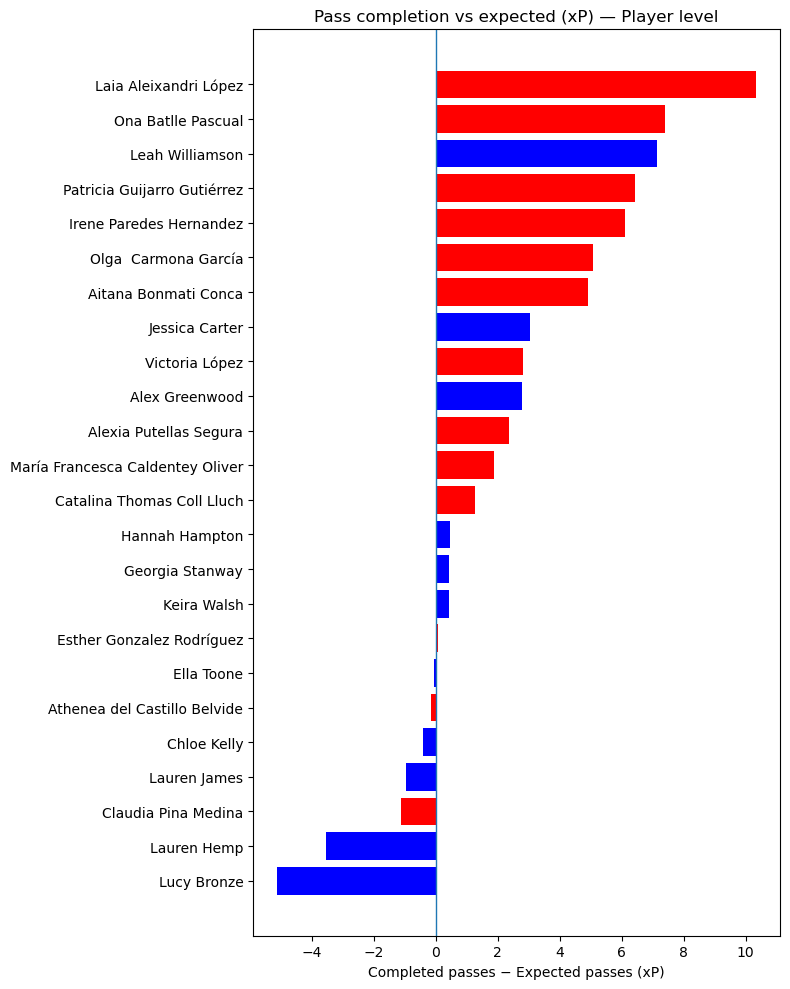

In [40]:
import matplotlib.pyplot as plt

df_plot = player_euros.copy()

# Optional: filter out very low volume players
df_plot = df_plot[df_plot["total_passes"] >= 10]

# Sort by difference
df_plot = df_plot.sort_values("diff")

# Team → colour mapping
team_colors = {
    "Spain Women's": "red",
    "England Women's": "blue",
}

colors = df_plot["team"].map(team_colors).fillna("grey")

plt.figure(figsize=(8, 10))
plt.barh(df_plot["player"], df_plot["diff"], color=colors)
plt.axvline(0, linewidth=1)

plt.xlabel("Completed passes − Expected passes (xP)")
plt.title("Pass completion vs expected (xP) — Player level")

plt.tight_layout()
plt.show()

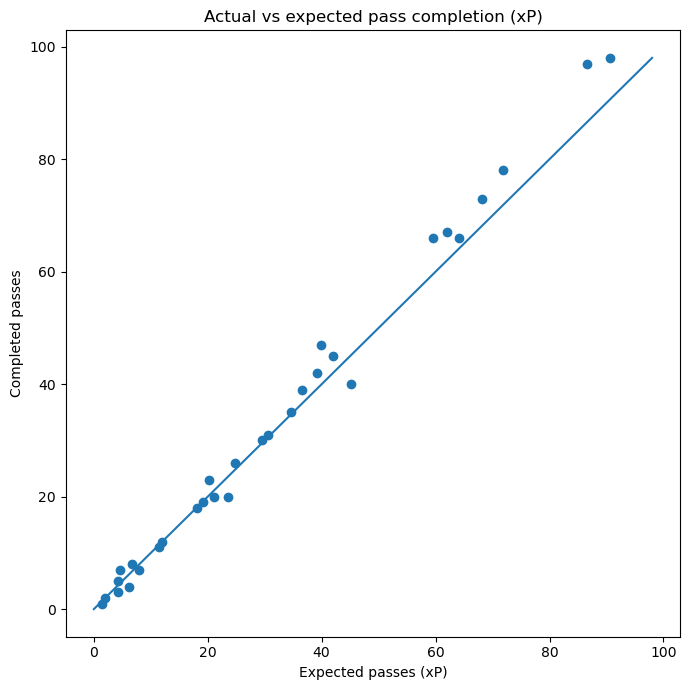

In [41]:
plt.figure(figsize=(7, 7))

plt.scatter(
    player_euros["total_xP"],
    player_euros["completed_passes"]
)

max_val = max(
    player_euros["total_xP"].max(),
    player_euros["completed_passes"].max()
)

plt.plot([0, max_val], [0, max_val])

plt.xlabel("Expected passes (xP)")
plt.ylabel("Completed passes")
plt.title("Actual vs expected pass completion (xP)")

plt.tight_layout()
plt.show()

In [42]:
team_world

,team,total_passes,completed_passes,total_xP,completion_rate_basic,diff,diff%
0,England Women's,408,293,291.570221,0.718137,1.429779,0.003504
1,Spain Women's,519,421,389.699737,0.811175,31.300263,0.060309


In [43]:
player_world

,player,team,total_passes,completed_passes,total_xP,completion_rate_basic,diff,diff%
0,Aitana Bonmati Conca,Spain Women's,45,41,34.484296,0.911111,6.515704,0.144793
1,Alba María Redondo Ferrer,Spain Women's,12,7,9.459676,0.583333,-2.459676,-0.204973
2,Alessia Russo,England Women's,12,5,8.024988,0.416667,-3.024988,-0.252082
3,Alex Greenwood,England Women's,54,40,40.935199,0.740741,-0.935199,-0.017318
4,Alexia Putellas Segura,Spain Women's,8,5,5.881144,0.625000,-0.881144,-0.110143
5,Bethany England,England Women's,4,3,3.195171,0.750000,-0.195171,-0.048793
6,Catalina Thomas Coll Lluch,Spain Women's,23,17,16.822926,0.739130,0.177074,0.007699
7,Chloe Kelly,England Women's,21,9,15.269526,0.428571,-6.269526,-0.298549
8,Ella Toone,England Women's,21,19,17.619939,0.904762,1.380061,0.065717
9,Georgia Stanway,England Women's,30,21,22.562275,0.700000,-1.562275,-0.052076


## Combined plots

In [44]:
df_euros_plot = player_euros.copy()
df_euros_plot["final"] = "Euros"

df_world_plot = player_world.copy()
df_world_plot["final"] = "World Cup"

df_plot = pd.concat([df_euros_plot, df_world_plot], ignore_index=True)

# Optional: filter low-volume performances
df_plot = df_plot[df_plot["total_passes"] >= 10]

In [45]:
df_plot = df_plot.sort_values(
    ["player", "final"],
    ascending=[True, False]  # World Cup first, Euros second
)

In [46]:
df_plot["total_passes_both_finals"] = (
    df_plot.groupby("player")["total_passes"]
    .transform("sum")
)

In [47]:
df_plot.head()

,player,team,total_passes,completed_passes,total_xP,completion_rate_basic,diff,diff%,final,total_passes_both_finals
31,Aitana Bonmati Conca,Spain Women's,45,41,34.484296,0.911111,6.515704,0.144793,World Cup,131
0,Aitana Bonmati Conca,Spain Women's,86,73,68.078933,0.848837,4.921067,0.057222,Euros,131
32,Alba María Redondo Ferrer,Spain Women's,12,7,9.459676,0.583333,-2.459676,-0.204973,World Cup,12
33,Alessia Russo,England Women's,12,5,8.024988,0.416667,-3.024988,-0.252082,World Cup,12
34,Alex Greenwood,England Women's,54,40,40.935199,0.740741,-0.935199,-0.017318,World Cup,105


In [48]:
team_colors = {
    "Spain Women's": "lightcoral",
    "England Women's": "royalblue",
}

df_plot["color"] = df_plot["team"].map(team_colors).fillna("grey")


In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Order players by average diff (nice narrative ordering)
player_order = (
    df_plot.groupby("player")["diff"]
    .mean()
    .sort_values()
    .index
)

y_base = np.arange(len(player_order))

# Map player → y position
y_map = dict(zip(player_order, y_base))

# Offsets for the two finals
offset = 0.18
df_plot["y"] = df_plot["player"].map(y_map)
df_plot["y_plot"] = np.where(
    df_plot["final"] == "World Cup",
    df_plot["y"] + offset,
    df_plot["y"] - offset,
)


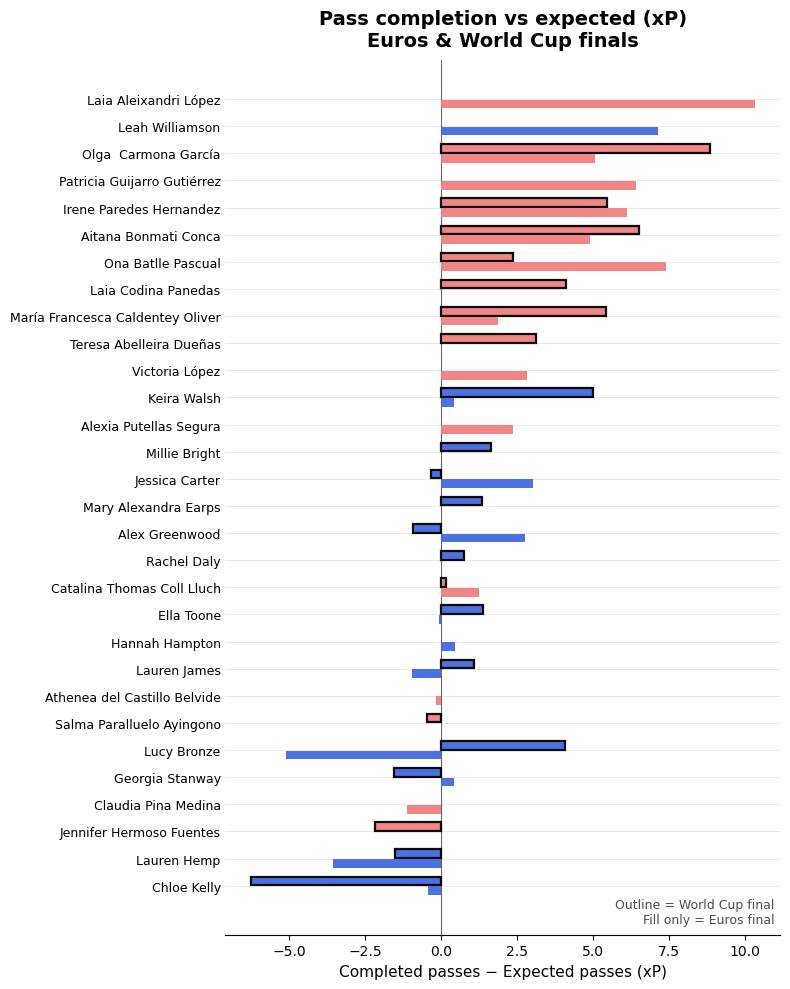

In [50]:
import matplotlib.pyplot as plt
import re

# Copy and filter
df_plot = df_plot.copy()
df_plot = df_plot[df_plot["total_passes_both_finals"] >= 15]

# Clean player names (remove trailing dash variants)
df_plot["player_clean"] = df_plot["player"].apply(
    lambda x: re.sub(r"[\s\-–—]+$", "", x)
)

# Order players by mean diff across finals
player_order = (
    df_plot.groupby("player_clean")["diff"]
    .mean()
    .sort_values()
    .index
    .tolist()
)

# Assign base y positions (one per player)
y_base = {p: i for i, p in enumerate(player_order)}

# Offset Euros / World Cup slightly
offset = {
    "Euros": -0.18,
    "World Cup": 0.18,
}

df_plot["y_plot"] = df_plot.apply(
    lambda r: y_base[r["player_clean"]] + offset[r["final"]],
    axis=1,
)

# ---- Plot ----
fig, ax = plt.subplots(figsize=(8, 10))

for _, r in df_plot.iterrows():
    ax.barh(
        y=r["y_plot"],
        width=r["diff"],
        height=0.32,
        color=r["color"],
        edgecolor="black" if r["final"] == "World Cup" else "none",
        linewidth=1.6 if r["final"] == "World Cup" else 0,
        alpha=0.95,
        zorder=3,
    )

# Zero reference line
ax.axvline(0, color="black", linewidth=0.8, alpha=0.6, zorder=2)

# Y-axis labels (players only once)
ax.set_yticks(list(y_base.values()))
ax.set_yticklabels(player_order, fontsize=9)

# Horizontal notebook-style guides
for y in y_base.values():
    ax.axhline(
        y=y,
        color="black",
        linewidth=0.4,
        alpha=0.15,
        zorder=1,
    )

# Labels & title
ax.set_xlabel("Completed passes − Expected passes (xP)", fontsize=11)
ax.set_title(
    "Pass completion vs expected (xP)\nEuros & World Cup finals",
    fontsize=14,
    weight="bold",
    pad=10,
)

# Minimal styling
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", length=0)

# Legend note
ax.text(
    0.99, 0.01,
    "Outline = World Cup final\nFill only = Euros final",
    transform=ax.transAxes,
    ha="right",
    va="bottom",
    fontsize=9,
    alpha=0.7,
)

plt.tight_layout()

plt.savefig("passcompletion.png", dpi=300, bbox_inches="tight")

plt.show()

### Update 14/02/2026: Download all datasets for future work.

In [ ]:
import os
import joblib


# SAVE LOCATION

SAVE_PATH = "Datasets/xP_master"
os.makedirs(SAVE_PATH, exist_ok=True)


# HELPER FUNCTION → SAVE PARQUET + CSV

def save_both(df, name, index=False):
    df.to_parquet(f"{SAVE_PATH}/{name}.parquet", index=index)
    df.to_csv(f"{SAVE_PATH}/{name}.csv", index=index)
    print(f"✔ saved {name}")


# CORE DATA

save_both(women_comps, "competitions")
save_both(matches_df, "matches")
save_both(passes_df, "passes_raw")


# FEATURE DATA + xP

save_both(df, "passes_features_with_xp")
save_both(X, "model_features_X")
save_both(y.to_frame("completed"), "model_target_y")
save_both(meta, "meta")

# Save feature list
with open(f"{SAVE_PATH}/feature_names.txt", "w") as f:
    for feat in FEATURES:
        f.write(feat + "\n")
print("✔ feature names saved")


# MODEL

joblib.dump(model, f"{SAVE_PATH}/xp_model.pkl")
print("✔ model saved")


# EUROS FINAL RESULTS

save_both(df_euros_feat, "euros_passes")
save_both(team_euros, "euros_team")
save_both(player_euros, "euros_player")


# WORLD FINAL RESULTS

save_both(df_world_feat, "world_passes")
save_both(team_world, "world_team")
save_both(player_world, "world_player")

print("\n✅ EVERYTHING SAVED SUCCESSFULLY (PARQUET + CSV)")

✔ saved competitions
✔ saved matches
